In [ ]:
!pip install yt_dlp
!pip show tensorflow | grep Version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 82.4 MB/s eta 0:00:00
Version: 2.19.0


In [1]:
# --------------------------
# 1 - installs, imports e diretórios (ATUALIZADO)
# --------------------------
# se rodando em notebook: descomente a linha abaixo para garantir libs
# !pip install numpy pandas matplotlib seaborn tqdm pillow librosa audioread yt-dlp ffmpeg-python scikit-learn xgboost tensorflow

import os, re, shutil, subprocess, math, random, json
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt

import librosa, librosa.display

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K, callbacks, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score
import xgboost as xgb
import seaborn as sns

# Fixar seeds
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# --------------------------
# Diretórios principais (ajuste conforme seu Drive)
# --------------------------

ROOT_DIR = "/content/drive/MyDrive/M.L_2UNIDADE"   # caminho principal do projeto da 2ª unidade

# Estrutura de pastas
CSV_DIR     = os.path.join(ROOT_DIR, "csv_files")              # arquivos CSV do dataset
COOKIES_DIR = os.path.join(ROOT_DIR, "cookies")                # cookies yt-dlp (opcional)
WAV_DIR     = os.path.join(ROOT_DIR, "wav_files")              # cortes de áudio WAV (10s)
IMG_DIR     = os.path.join(ROOT_DIR, "data-files")             # espectrogramas originais
AUG_DIR     = os.path.join(ROOT_DIR, "data-files-augmented")   # espectrogramas com augmentations
MODEL_DIR   = os.path.join(ROOT_DIR, "models_unit2")           # modelos treinados (VAE, CNNs)
RESULTS_DIR = os.path.join(ROOT_DIR, "results_unit2")          # métricas, curvas ROC, matrizes de confusão

# Criar diretórios caso não existam
for d in [CSV_DIR, COOKIES_DIR, WAV_DIR, IMG_DIR, AUG_DIR, MODEL_DIR, RESULTS_DIR]:
    os.makedirs(d, exist_ok=True)

# Caminhos específicos
CSV_PATH     = os.path.join(CSV_DIR, "unbalanced_train_segments.csv")  # caminho do CSV principal
COOKIES_PATH = os.path.join(COOKIES_DIR, "www.youtube.com_cookies.txt")                 # cookies yt-dlp (se necessário)

# --------------------------
# Parâmetros principais
# --------------------------
TARGET_PER_CLASS = 250    # número de músicas por gênero
SR = 22050                # sample rate
CLIP_DURATION = 10        # duração dos clipes em segundos
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32
VAE_EPOCHS = 80
CLASS_EPOCHS = 30
LATENT_DIM = 128
NOISE_FACTOR = 0.08
SPEC_AUG_TIME_MASKS = 2
SPEC_AUG_FREQ_MASKS = 2

RANDOM_STATE = SEED

# --------------------------
# Gêneros alvo (iguais ao código original; pode ajustar se quiser)
# --------------------------
genre_dict = {
    '/m/064t9': 'Pop_music',
    '/m/0glt670': 'Hip_hop_music',
    '/m/06by7': 'Rock_music',
    '/m/06j6l': 'Rhythm_blues',
    '/m/06cqb': 'Reggae',
    '/m/0y4f8': 'Vocal',
    '/m/07gxw': 'Techno',
}


In [2]:
# --------------------------
# Helpers utilitários
# --------------------------
def ensure_empty_dir(d):
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

def save_json(obj, path):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)

def plot_and_save_fig(fig, filename):
    fig.tight_layout()
    fig.savefig(filename, dpi=200)
    plt.close(fig)

In [3]:
# --------------------------
# 2 - carregamento do dataset (leitura do CSV e filtragem por gêneros)
# --------------------------
print("Etapa 2: lendo CSV e preparando candidatos...")
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV não encontrado em {CSV_PATH} - verifique caminho")

data = []
with open(CSV_PATH, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        elements = re.sub(r'["\n]', "", line).split(",")
        if len(elements) >= 4:
            url = elements[0]; start = elements[1]; end = elements[2]; labels = elements[3:]
            for label in labels:
                if label in genre_dict:
                    data.append([url, start, end, genre_dict[label]])
df = pd.DataFrame(data, columns=["url", "start_time", "end_time", "class_label"])
df.to_csv(os.path.join(ROOT_DIR, "df_candidates_unit2.csv"), index=False)
print("Total candidatos lidos:", len(df))
print(df["class_label"].value_counts())

Etapa 2: lendo CSV e preparando candidatos...
Total candidatos lidos: 51710
class_label
Techno           16811
Pop_music         8407
Rock_music        8198
Hip_hop_music     7370
Rhythm_blues      4755
Vocal             3241
Reggae            2928
Name: count, dtype: int64


In [ ]:
# --------------------------
# 3 - corte dos vídeos (download e cut) — com retomada ordenada
# --------------------------
COOKIES_PATH = os.path.join(COOKIES_DIR, "www.youtube.com_cookies.txt")
print("\nEtapa 3: Download e corte dos vídeos (com retomada ordenada e verificação incremental).")

import yt_dlp
import pandas as pd
import os, subprocess

# 🔸 NÃO limpar o diretório
os.makedirs(WAV_DIR, exist_ok=True)

# 🔸 Verificar progresso anterior
progress_file = os.path.join(ROOT_DIR, "df_success_unit2.csv")
if os.path.exists(progress_file):
    df_success = pd.read_csv(progress_file)
    downloaded_ids = set(df_success["url"].astype(str))
    print(f"✅ Retomando: {len(downloaded_ids)} vídeos já baixados com sucesso.")
else:
    df_success = pd.DataFrame(columns=["url", "start_time", "end_time", "class_label"])
    downloaded_ids = set()

# 🔸 Contar quantos arquivos WAV já existem por gênero
existing_files = [f for f in os.listdir(WAV_DIR) if f.endswith(".wav")]
existing_counts = {}
for f in existing_files:
    try:
        genre_name = f.split("_", 1)[1][:-4]
        existing_counts[genre_name] = existing_counts.get(genre_name, 0) + 1
    except:
        continue

counts = {label: existing_counts.get(label, 0) for label in genre_dict.values()}
print("📊 Arquivos já existentes por gênero:", counts)

# 🔸 Determinar o último vídeo baixado com sucesso (para cada gênero)
last_positions = {}
if not df_success.empty:
    for genre in df_success["class_label"].unique():
        last_url = df_success[df_success["class_label"] == genre]["url"].iloc[-1]
        try:
            pos = df[df["url"] == last_url].index[-1]
            last_positions[genre] = pos
        except IndexError:
            pass

# 🔸 Função auxiliar: verificar se já existe WAV
def wav_exists(video_id, label):
    pattern = f"{video_id}_{label}.wav"
    return any(pattern in f for f in existing_files)

# 🔸 Baixar somente os gêneros incompletos, continuando do último baixado
downloaded_rows = []
for label, group in df.groupby("class_label"):
    current_count = counts.get(label, 0)
    if current_count >= TARGET_PER_CLASS:
        print(f"✅ {label} já completo ({current_count}/{TARGET_PER_CLASS}) - pulando.")
        continue

    # se houver posição salva, começa dali
    start_index = last_positions.get(label, group.index[0])
    group = group.loc[group.index >= start_index]

    needed = TARGET_PER_CLASS - current_count
    print(f"\n🔹 {label}: precisa baixar {needed} arquivos (continuando após índice {start_index}).")

    for idx, row in group.iterrows():
        vid = str(row["url"])
        start = float(row["start_time"])
        url = f"https://www.youtube.com/watch?v={vid}"
        final_file = os.path.join(WAV_DIR, f"{vid}_{label}.wav")

        # já baixado? pula
        if vid in downloaded_ids or wav_exists(vid, label):
            continue
        if counts[label] >= TARGET_PER_CLASS:
            print(f"🎯 {label} atingiu {TARGET_PER_CLASS}, parando.")
            break

        temp_out = os.path.join(WAV_DIR, f"temp_{vid}.%(ext)s")
        try:
            ydl_opts = {
                "format": "bestaudio/best",
                "outtmpl": temp_out,
                "quiet": True,
                "noplaylist": True
            }
            if os.path.exists(COOKIES_PATH):
                ydl_opts["cookiefile"] = COOKIES_PATH

            with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                ydl.download([url])

            temp_files = [f for f in os.listdir(WAV_DIR) if f.startswith(f"temp_{vid}")]
            if not temp_files:
                print(f"⚠️ Nenhum arquivo temporário gerado para {vid}")
                continue

            temp_file = os.path.join(WAV_DIR, temp_files[0])
            subprocess.run([
                "ffmpeg", "-y", "-ss", str(start), "-t", str(CLIP_DURATION),
                "-i", temp_file, "-acodec", "pcm_s16le", "-ar", str(SR), "-ac", "1", final_file
            ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

            os.remove(temp_file)
            if os.path.exists(final_file):
                counts[label] += 1
                downloaded_rows.append(row)
                downloaded_ids.add(vid)

                # salvar progresso incremental
                pd.concat([df_success, pd.DataFrame([row])]).to_csv(progress_file, index=False)

                if counts[label] % 10 == 0:
                    print(f"🎵 {counts[label]} baixados para {label}")

            else:
                print(f"⚠️ WAV não gerado para {vid}")

        except Exception as e:
            print(f"❌ Erro ao baixar {vid}: {e}")
            continue

# 🔸 Salvar resumo
summary = pd.DataFrame(list(counts.items()), columns=["genre", "count"])
summary.to_csv(os.path.join(ROOT_DIR, "dataset_summary_unit2.csv"), index=False)

print("\n✅ Download finalizado.")
for g, c in counts.items():
    print(f" - {g}: {c}/{TARGET_PER_CLASS}")
print("Progresso salvo em dataset_summary_unit2.csv e df_success_unit2.csv")



Etapa 3: Download e corte dos vídeos (com retomada ordenada e verificação incremental).


ModuleNotFoundError: No module named 'yt_dlp'

In [ ]:
# --------------------------
# 🔍 Verificação e balanceamento dos arquivos WAV
# --------------------------
print("\n=== Verificando e balanceando os arquivos WAV ===")

import random
from collections import defaultdict, Counter

# listar todos os arquivos .wav
wav_files = [f for f in os.listdir(WAV_DIR) if f.endswith(".wav")]
if not wav_files:
    print("⚠️ Nenhum arquivo WAV encontrado em", WAV_DIR)

# 1️⃣ Contar arquivos por gênero
wav_by_genre = defaultdict(list)
for f in wav_files:
    try:
        genre = f.split("_")[-1].replace(".wav", "")
        wav_by_genre[genre].append(f)
    except:
        continue

print("\n🎵 Contagem inicial por gênero:")
for g, lst in wav_by_genre.items():
    print(f" - {g}: {len(lst)}")

# 2️⃣ Identificar duplicados pelo ID do vídeo
ids_seen = set()
duplicates = []
for f in wav_files:
    vid_id = f.split("_")[0]
    if vid_id in ids_seen:
        duplicates.append(f)
    ids_seen.add(vid_id)

# Remover duplicados
for dup in duplicates:
    try:
        os.remove(os.path.join(WAV_DIR, dup))
    except:
        pass

print(f"\n🔁 Duplicados removidos: {len(duplicates)}")

# 3️⃣ Verificar e eliminar excessos (> TARGET_PER_CLASS)
for genre, files in wav_by_genre.items():
    # Atualizar lista após remoção
    current_files = [f for f in os.listdir(WAV_DIR) if f.endswith(f"_{genre}.wav")]
    if len(current_files) > TARGET_PER_CLASS:
        excess = len(current_files) - TARGET_PER_CLASS
        to_remove = random.sample(current_files, excess)
        for f in to_remove:
            os.remove(os.path.join(WAV_DIR, f))
        print(f"⚖️ {genre}: removidos {excess} arquivos aleatórios para balancear ({TARGET_PER_CLASS} restantes).")

# 4️⃣ Contagem final
final_counts = Counter([f.split("_")[-1].replace(".wav", "") for f in os.listdir(WAV_DIR) if f.endswith(".wav")])
print("\n✅ Contagem final por gênero:")
for g, c in final_counts.items():
    print(f" - {g}: {c}")



=== Verificando e balanceando os arquivos WAV ===

🎵 Contagem inicial por gênero:
 - Reggae: 250
 - music: 250
 - blues: 250
 - Techno: 250
 - Vocal: 250

🔁 Duplicados removidos: 0

✅ Contagem final por gênero:
 - Reggae: 250
 - music: 250
 - blues: 250
 - Techno: 250
 - Vocal: 250


In [ ]:
# --------------------------
# 4 - Gerar os espectrogramas (MEL) - corrigido e incremental
# --------------------------
print("\nEtapa 4: Gerando espectrogramas MEL (uma pasta por gênero, incremental).")

import librosa, librosa.display
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Não limpar o diretório (mantém espectrogramas já gerados)
os.makedirs(IMG_DIR, exist_ok=True)

# Lista de arquivos WAV
wav_files = [f for f in os.listdir(WAV_DIR) if f.endswith(".wav")]
if not wav_files:
    print("⚠️ Nenhum arquivo WAV encontrado em", WAV_DIR)

# Gera espectrograma apenas se ainda não existir o arquivo .jpg correspondente
for f in tqdm(wav_files, desc="Gerando espectrogramas"):
    try:
        # Gênero é a parte depois do último "_"
        parts = f.split("_")
        class_name = parts[-1].replace(".wav", "")
        class_dir = os.path.join(IMG_DIR, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # Caminho de saída do espectrograma
        output_path = os.path.join(class_dir, f.replace(".wav", ".jpg"))
        if os.path.exists(output_path):
            continue  # pula se já existe

        # Carregar o áudio
        y, sr = librosa.load(os.path.join(WAV_DIR, f), sr=SR)
        y = np.append(y[0], y[1:] - 0.97*y[:-1])  # pre-emphasis

        # Gerar espectrograma MEL (igual ao artigo original)
        M = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048,
                                           hop_length=512, n_mels=96, fmax=sr/2)
        log_power = librosa.power_to_db(M, ref=np.max)

        # Plotar e salvar imagem (sem eixos, fundo limpo)
        plt.figure(figsize=(3, 3))
        plt.axis("off")
        librosa.display.specshow(log_power, cmap="jet", sr=sr, hop_length=512)
        plt.savefig(output_path, bbox_inches="tight", pad_inches=0)
        plt.close()

    except Exception as e:
        print("Erro ao processar", f, "→", e)

# Contar quantas imagens por gênero
counts_img = {}
for g in os.listdir(IMG_DIR):
    gp = os.path.join(IMG_DIR, g)
    if os.path.isdir(gp):
        counts_img[g] = len([x for x in os.listdir(gp) if x.lower().endswith(".jpg")])

# Salvar estatísticas
pd.DataFrame(list(counts_img.items()), columns=["genre", "images"])\
  .to_csv(os.path.join(ROOT_DIR, "image_counts_unit2.csv"), index=False)

print("\n✅ Contagem de espectrogramas salva em image_counts_unit2.csv")
print("Resumo:", counts_img)



Etapa 4: Gerando espectrogramas MEL (uma pasta por gênero, incremental).


Gerando espectrogramas: 100%|██████████| 1250/1250 [03:19<00:00,  6.26it/s]


✅ Contagem de espectrogramas salva em image_counts_unit2.csv
Resumo: {'blues': 250, 'music': 250, 'Techno': 250, 'Vocal': 250, 'Reggae': 250}


In [ ]:
# --------------------------
# 🔍 Verificação e balanceamento dos espectrogramas
# --------------------------
print("\n=== Verificando e balanceando os espectrogramas ===")

import random
from collections import defaultdict, Counter

# 1️⃣ Contar arquivos por gênero
jpg_by_genre = defaultdict(list)
for genre_folder in os.listdir(IMG_DIR):
    genre_path = os.path.join(IMG_DIR, genre_folder)
    if not os.path.isdir(genre_path):
        continue
    for f in os.listdir(genre_path):
        if f.endswith(".jpg"):
            jpg_by_genre[genre_folder].append(f)

print("\n🖼️ Contagem inicial por gênero:")
for g, lst in jpg_by_genre.items():
    print(f" - {g}: {len(lst)}")

# 2️⃣ Identificar e remover duplicados
duplicates_jpg = []
for genre, files in jpg_by_genre.items():
    ids_seen = set()
    for f in files:
        vid_id = f.split("_")[0]
        if vid_id in ids_seen:
            duplicates_jpg.append((genre, f))
        ids_seen.add(vid_id)

for genre, f in duplicates_jpg:
    try:
        os.remove(os.path.join(IMG_DIR, genre, f))
    except:
        pass

print(f"\n🔁 Duplicados removidos: {len(duplicates_jpg)}")

# 3️⃣ Se houver mais de TARGET_PER_CLASS, remover aleatoriamente
for genre, files in jpg_by_genre.items():
    current_files = [f for f in os.listdir(os.path.join(IMG_DIR, genre)) if f.endswith(".jpg")]
    if len(current_files) > TARGET_PER_CLASS:
        excess = len(current_files) - TARGET_PER_CLASS
        to_remove = random.sample(current_files, excess)
        for f in to_remove:
            os.remove(os.path.join(IMG_DIR, genre, f))
        print(f"⚖️ {genre}: removidos {excess} espectrogramas aleatórios (ficaram {TARGET_PER_CLASS}).")

# 4️⃣ Contagem final
final_counts_jpg = {}
for genre in os.listdir(IMG_DIR):
    genre_path = os.path.join(IMG_DIR, genre)
    if os.path.isdir(genre_path):
        count = len([f for f in os.listdir(genre_path) if f.endswith(".jpg")])
        final_counts_jpg[genre] = count

print("\n✅ Contagem final por gênero:")
for g, c in final_counts_jpg.items():
    print(f" - {g}: {c}")



=== Verificando e balanceando os espectrogramas ===

🖼️ Contagem inicial por gênero:
 - blues: 250
 - music: 250
 - Techno: 250
 - Vocal: 250
 - Reggae: 250

🔁 Duplicados removidos: 0

✅ Contagem final por gênero:
 - blues: 250
 - music: 250
 - Techno: 250
 - Vocal: 250
 - Reggae: 250


In [6]:
# --------------------------
# 5 - Criar e treinar o Autoencoder Variacional (VAE) – versão compatível TF 2.19 (loop manual)
# --------------------------
print("\nEtapa 5: Criando e treinando o VAE refinado (loop manual compatível TF 2.19).")

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, gc, numpy as np

# --------------------------
# CONFIGURAÇÕES
# --------------------------
latent_dim = 32
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
epochs = 40

vae_weights_path = os.path.join(MODEL_DIR, "vae_unit2_refined.weights.h5")
encoder_path = os.path.join(MODEL_DIR, "encoder_unit2_refined.keras")
decoder_path = os.path.join(MODEL_DIR, "decoder_unit2_refined.keras")

# --------------------------
# DATASET
# --------------------------
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_gen = datagen.flow_from_directory(
    IMG_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode=None,
    subset='training',
    shuffle=True,
    seed=SEED
)

val_gen = datagen.flow_from_directory(
    IMG_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode=None,
    subset='validation',
    shuffle=True,
    seed=SEED
)

# --------------------------
# ENCODER
# --------------------------
encoder_inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

@tf.keras.utils.register_keras_serializable()
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# --------------------------
# DECODER
# --------------------------
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(28 * 28 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((28, 28, 128))(x)
x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")

# --------------------------
# FUNÇÃO DE TREINO MANUAL
# --------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder(batch)
        reconstruction = decoder(z)
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(batch - reconstruction), axis=(1, 2, 3)))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        total_loss = recon_loss + 0.001 * kl_loss
    grads = tape.gradient(total_loss, encoder.trainable_weights + decoder.trainable_weights)
    optimizer.apply_gradients(zip(grads, encoder.trainable_weights + decoder.trainable_weights))
    return total_loss, recon_loss, kl_loss

# --------------------------
# LOOP DE TREINAMENTO
# --------------------------
if not os.path.exists(vae_weights_path):
    print("🧠 Treinando VAE refinado (modo manual)...")
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        epoch_loss, epoch_recon, epoch_kl = [], [], []
        for step, batch in enumerate(train_gen):
            total_loss, recon_loss, kl_loss = train_step(batch)
            epoch_loss.append(total_loss.numpy())
            epoch_recon.append(recon_loss.numpy())
            epoch_kl.append(kl_loss.numpy())

            if step % 10 == 0:
                print(f"Step {step:03d}: loss={total_loss:.2f}, recon={recon_loss:.2f}, kl={kl_loss:.2f}")

            if step >= len(train_gen) - 1:
                break

        print(f"Epoch {epoch+1} - loss={np.mean(epoch_loss):.2f} - recon={np.mean(epoch_recon):.2f} - kl={np.mean(epoch_kl):.2f}")

    encoder.save(encoder_path)
    decoder.save(decoder_path)
    encoder.save_weights(vae_weights_path.replace(".weights.h5", "_enc.weights.h5"))
    decoder.save_weights(vae_weights_path.replace(".weights.h5", "_dec.weights.h5"))
    print("✅ VAE treinado e salvo com sucesso.")
else:
    print("⚙️ Carregando pesos existentes do VAE...")
    encoder.load_weights(vae_weights_path.replace(".weights.h5", "_enc.weights.h5"))
    decoder.load_weights(vae_weights_path.replace(".weights.h5", "_dec.weights.h5"))
    print("✅ Modelos encoder e decoder carregados.")



Etapa 5: Criando e treinando o VAE refinado (loop manual compatível TF 2.19).
Found 1125 images belonging to 5 classes.
Found 125 images belonging to 5 classes.
🧠 Treinando VAE refinado (modo manual)...

Epoch 1/40
Step 000: loss=20271.74, recon=20271.74, kl=0.13
Step 010: loss=19803.59, recon=19803.44, kl=155.82
Step 020: loss=18954.94, recon=18952.00, kl=2938.48
Step 030: loss=14879.28, recon=14850.02, kl=29253.98
Epoch 1 - loss=18147.95 - recon=18138.88 - kl=9069.34

Epoch 2/40
Step 000: loss=13291.15, recon=13256.37, kl=34784.86
Step 010: loss=11945.12, recon=11917.82, kl=27298.04
Step 020: loss=10832.13, recon=10805.61, kl=26522.78
Step 030: loss=9724.75, recon=9696.44, kl=28315.69
Epoch 2 - loss=11108.01 - recon=11079.97 - kl=28043.49

Epoch 3/40
Step 000: loss=10592.57, recon=10570.68, kl=21889.10
Step 010: loss=10694.15, recon=10674.99, kl=19158.77
Step 020: loss=9635.78, recon=9616.19, kl=19589.05
Step 030: loss=10238.29, recon=10220.16, kl=18123.82
Epoch 3 - loss=10166.11 - 

In [7]:
# --------------------------
# 6 - Criar augmentações (limitado a 250 novas por gênero)
# --------------------------
print("\nEtapa 6: Criando augmentações equilibradas (máx. 250 por gênero).")

import numpy as np
import random
from tqdm import tqdm
from PIL import Image, ImageFilter
import shutil

# Carrega modelos refinados
encoder = tf.keras.models.load_model(encoder_path, custom_objects={"sampling": sampling})
decoder = tf.keras.models.load_model(decoder_path, custom_objects={"sampling": sampling})

# Limpar e recriar diretório
shutil.rmtree(AUG_DIR, ignore_errors=True)
os.makedirs(AUG_DIR, exist_ok=True)

# Coletar imagens originais
class_dirs = [d for d in os.listdir(IMG_DIR) if os.path.isdir(os.path.join(IMG_DIR, d))]

for cls in class_dirs:
    print(f"\nGerando augmentations para {cls}...")
    src_dir = os.path.join(IMG_DIR, cls)
    dst_dir = os.path.join(AUG_DIR, cls)
    os.makedirs(dst_dir, exist_ok=True)

    files = [f for f in os.listdir(src_dir) if f.endswith(".jpg")]
    selected_files = random.sample(files, min(250, len(files)))

    for f in tqdm(selected_files):
        img = Image.open(os.path.join(src_dir, f)).convert("RGB")
        arr = np.array(img.resize((IMG_WIDTH, IMG_HEIGHT))) / 255.0
        arr = np.expand_dims(arr, 0)

        z_mean, z_log_var, z = encoder.predict(arr, verbose=0)
        z_shifted = z + np.random.normal(0, 0.2, z.shape)
        recon = decoder.predict(z_shifted, verbose=0)[0]

        # Pós-processamento: suavização + realce de contraste
        recon = np.clip(recon * 255, 0, 255).astype(np.uint8)
        recon_img = Image.fromarray(recon).filter(ImageFilter.SMOOTH_MORE)
        recon_img.save(os.path.join(dst_dir, f"aug_{f}"))



Etapa 6: Criando augmentações equilibradas (máx. 250 por gênero).

Gerando augmentations para blues...


100%|██████████| 250/250 [00:42<00:00,  5.89it/s]



Gerando augmentations para music...


100%|██████████| 250/250 [00:40<00:00,  6.13it/s]



Gerando augmentations para Techno...


100%|██████████| 250/250 [00:40<00:00,  6.21it/s]



Gerando augmentations para Vocal...


100%|██████████| 250/250 [00:39<00:00,  6.39it/s]



Gerando augmentations para Reggae...


100%|██████████| 250/250 [00:38<00:00,  6.42it/s]


In [8]:
# --------------------------
# 7 - Treinar CNN baseline e CNN com augmentações (VGG16, otimizada)
# --------------------------
print("\nEtapa 7: Treinar CNN baseline e augmented (execução separada para evitar travamentos)")

import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

# --------------------------
# FUNÇÃO DE CONSTRUÇÃO DO MODELO VGG16
# --------------------------
def build_vgg16_cnn(input_shape=(224, 224, 3), num_classes=5):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # congelar camadas base

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --------------------------
# CONFIGURAÇÕES DE DADOS
# --------------------------
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# --- Dataset BASELINE ---
print("Preparando dados para CNN baseline...")
train_gen_base = datagen.flow_from_directory(
    IMG_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)
val_gen_base = datagen.flow_from_directory(
    IMG_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=SEED
)

# --------------------------
# TREINAR CNN BASELINE
# --------------------------
cnn_base = build_vgg16_cnn(num_classes=train_gen_base.num_classes)
print("\nTreinando CNN baseline (somente dados originais)...")

history_base = cnn_base.fit(
    train_gen_base,
    validation_data=val_gen_base,
    epochs=15,
    verbose=1
)

cnn_base.save(os.path.join(MODEL_DIR, "cnn_vgg16_baseline.keras"))
print("✅ CNN baseline treinada e salva.")

# Salvar histórico baseline
import pickle
with open(os.path.join(MODEL_DIR, "history_baseline.pkl"), "wb") as f:
    pickle.dump(history_base.history, f)

# --------------------------
# LIMPAR MEMÓRIA ANTES DO AUGMENTED
# --------------------------
del cnn_base, train_gen_base, val_gen_base
gc.collect()
tf.keras.backend.clear_session()

# --------------------------
# TREINAR CNN COM AUGMENTAÇÕES
# --------------------------
print("\nPreparando dados para CNN com augmentações...")

datagen_aug = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen_aug = datagen_aug.flow_from_directory(
    AUG_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)
val_gen_aug = datagen_aug.flow_from_directory(
    AUG_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=SEED
)

cnn_aug = build_vgg16_cnn(num_classes=train_gen_aug.num_classes)
print("\nTreinando CNN com augmentações (dados artificiais + originais)...")

history_aug = cnn_aug.fit(
    train_gen_aug,
    validation_data=val_gen_aug,
    epochs=15,
    verbose=1
)

cnn_aug.save(os.path.join(MODEL_DIR, "cnn_vgg16_augmented.keras"))
print("✅ CNN com augmentações treinada e salva.")

# Salvar histórico augmented
with open(os.path.join(MODEL_DIR, "history_augmented.pkl"), "wb") as f:
    pickle.dump(history_aug.history, f)

print("\n🎯 Ambas as CNNs (baseline e augmented) foram treinadas e salvas com sucesso!")



Etapa 7: Treinar CNN baseline e augmented (execução separada para evitar travamentos)
Preparando dados para CNN baseline...
Found 1000 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Treinando CNN baseline (somente dados originais)...
Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2674 - loss: 1.7426 - val_accuracy: 0.4040 - val_loss: 1.3857
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.4297 - loss: 1.3242 - val_accuracy: 0.4280 - val_loss: 1.3419
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.4977 - loss: 1.1973 - val_accuracy: 0.4680 - val_loss: 1.2982
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.5378 - loss: 1.1351 - val_accuracy: 0.5000 - val_loss: 1.2623
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.5867 - loss: 1.0470 - val_accuracy: 0.4360 - val_loss: 1.2895
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/ste


Etapa 8: avaliando e plotando desempenho das CNNs baseline e augmentada
✅ Históricos de treino detectados. Gerando gráficos...
Métricas encontradas no histórico baseline: ['accuracy', 'loss', 'val_accuracy', 'val_loss']


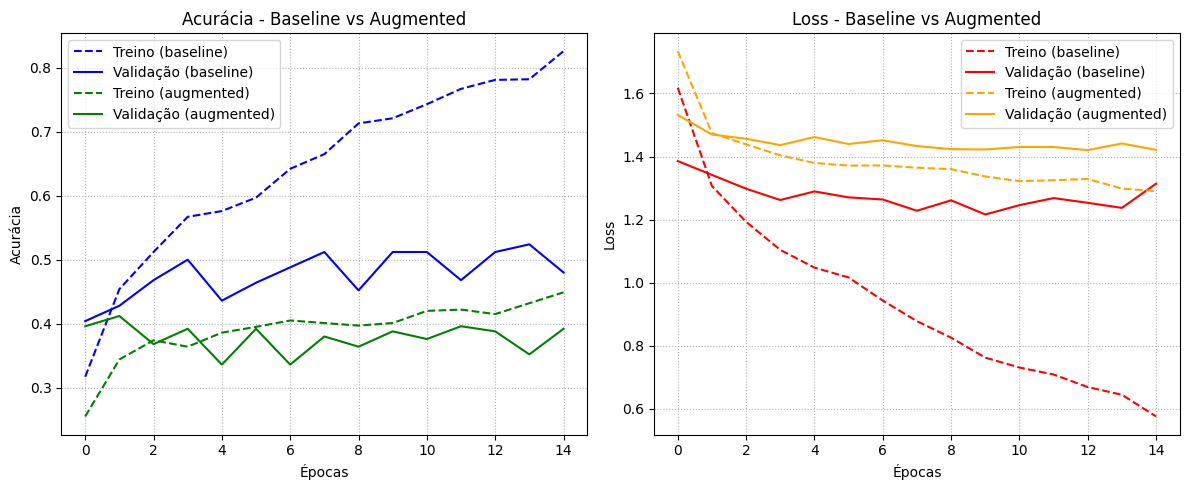

,Modelo,Acurácia Val. Final,Loss Val. Final
0,CNN Baseline,0.480,1.314140
1,CNN + Augmentações,0.392,1.421037



✅ Gráficos e tabela comparativa gerados com sucesso!


In [9]:
# --------------------------
# 8 - Avaliação e Visualização dos Resultados
# --------------------------
print("\nEtapa 8: avaliando e plotando desempenho das CNNs baseline e augmentada")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------------------------------------------
# Verificar se histories estão disponíveis
# ---------------------------------------------------
if 'history_base' not in locals() or 'history_aug' not in locals():
    print("⚠️ Históricos de treino não encontrados. Certifique-se de ter executado a Etapa 7 corretamente.")
else:
    print("✅ Históricos de treino detectados. Gerando gráficos...")

    # Extrair dicionários de histórico
    hist_base = history_base.history
    hist_aug = history_aug.history

    # ---------------------------------------------------
    # Normalizar nomes de chaves (às vezes vêm com 'val_val_')
    # ---------------------------------------------------
    def clean_keys(d):
        clean = {}
        for k, v in d.items():
            new_k = k.replace("val_val_", "val_")
            clean[new_k] = v
        return clean

    hist_base = clean_keys(hist_base)
    hist_aug = clean_keys(hist_aug)

    # ---------------------------------------------------
    # Garantir que existam métricas esperadas
    # ---------------------------------------------------
    metrics_available = list(hist_base.keys())
    print(f"Métricas encontradas no histórico baseline: {metrics_available}")

    # ---------------------------------------------------
    # Plotar gráficos
    # ---------------------------------------------------
    plt.figure(figsize=(12, 5))

    # 🟦 Acurácia
    if "accuracy" in hist_base and "val_accuracy" in hist_base:
        plt.subplot(1, 2, 1)
        plt.plot(hist_base["accuracy"], label="Treino (baseline)", color='blue', linestyle='--')
        plt.plot(hist_base["val_accuracy"], label="Validação (baseline)", color='blue')
        plt.plot(hist_aug["accuracy"], label="Treino (augmented)", color='green', linestyle='--')
        plt.plot(hist_aug["val_accuracy"], label="Validação (augmented)", color='green')
        plt.title("Acurácia - Baseline vs Augmented")
        plt.xlabel("Épocas")
        plt.ylabel("Acurácia")
        plt.legend()
        plt.grid(True, linestyle=':')

    # 🟥 Loss
    if "loss" in hist_base and "val_loss" in hist_base:
        plt.subplot(1, 2, 2)
        plt.plot(hist_base["loss"], label="Treino (baseline)", color='red', linestyle='--')
        plt.plot(hist_base["val_loss"], label="Validação (baseline)", color='red')
        plt.plot(hist_aug["loss"], label="Treino (augmented)", color='orange', linestyle='--')
        plt.plot(hist_aug["val_loss"], label="Validação (augmented)", color='orange')
        plt.title("Loss - Baseline vs Augmented")
        plt.xlabel("Épocas")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True, linestyle=':')

    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------
    # Tabela comparativa final (última época)
    # ---------------------------------------------------
    last_base_acc = hist_base.get("val_accuracy", [None])[-1]
    last_aug_acc = hist_aug.get("val_accuracy", [None])[-1]
    last_base_loss = hist_base.get("val_loss", [None])[-1]
    last_aug_loss = hist_aug.get("val_loss", [None])[-1]

    df_comp = pd.DataFrame({
        "Modelo": ["CNN Baseline", "CNN + Augmentações"],
        "Acurácia Val. Final": [last_base_acc, last_aug_acc],
        "Loss Val. Final": [last_base_loss, last_aug_loss]
    })
    display(df_comp)

    print("\n✅ Gráficos e tabela comparativa gerados com sucesso!")
